In [4]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, RepeatVector
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [6]:
import re
import pandas as pd
from numpy import array

# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')

        # read all text
        text = file.read()
        file.close()
        return text
# Let’s define another function to split the text into English-German pairs separated by ‘\n’. We’ll then split these pairs into English sentences and German sentences respectively.
# split a text into sentences

def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

#We can now use these functions to read the text into an array in our desired format.

data = read_text("/content/deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

print(data[0:175])

Go.	Geh.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)
Hi.	Hallo!	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)


In [7]:
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['It may be impossible to get a completely error-free corpus due to the nature of this kind of collaborative effort. However, if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning, we might be able to minimize errors.',
        'Es ist wohl unmöglich, einen vollkommen fehlerfreien Korpus zu erreichen\xa0— das liegt in der Natur eines solchen Gemeinschaftsprojekts. Doch wenn wir unsere Mitglieder dazu bringen können, nicht mit Sprachen herumzuexperimentieren, die sie gerade lernen, sondern Sätze in ihrer eigenen Muttersprache beizutragen, dann gelingt 

In [8]:
deu_eng = deu_eng[:50000,:]

In [9]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

deu_eng

array([['Go', 'Geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi', 'Hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi', 'Grüß Gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['I heard you did well',
        'Ich habe gehört Sie haben gut abgeschnitten',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2360805 (CK) & #2633620 (raggione)'],
       ['I heard you laughing', 'Ich habe dich lachen gehört',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2360813 (CK) & #2633613 (raggione)'],
       ['I heard you laughing', 'Ich habe euch lachen gehört',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2360813 (CK) & #2633614 (raggione)']],
      dtype='<U537')

In [10]:
# convert text to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

deu_eng

array([['go', 'geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['hi', 'hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['hi', 'grüß gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['i heard you did well',
        'ich habe gehört sie haben gut abgeschnitten',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2360805 (CK) & #2633620 (raggione)'],
       ['i heard you laughing', 'ich habe dich lachen gehört',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2360813 (CK) & #2633613 (raggione)'],
       ['i heard you laughing', 'ich habe euch lachen gehört',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2360813 (CK) & #2633614 (raggione)']],
      dtype='<U537')

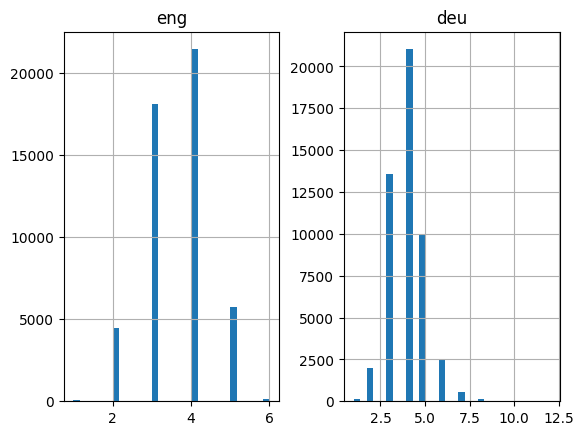

In [11]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)
plt.show()

In [12]:
# function to build a tokenizer
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [13]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6098


In [14]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10071


In [15]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
  # integer encode sequences
  seq = tokenizer.texts_to_sequences(lines)
  # pad sequences with 0 values
  seq = pad_sequences(seq, maxlen=length, padding='post')
  return seq

In [16]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [17]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [18]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [19]:
# model compilation
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop( learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [20]:
filename = 'model.h1.23_Nov_24.keras'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint],
                    verbose=1)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - loss: 5.7043
Epoch 1: val_loss improved from inf to 3.03860, saving model to model.h1.23_Nov_24.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 235ms/step - loss: 5.6806 - val_loss: 3.0386
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - loss: 2.9234
Epoch 2: val_loss improved from 3.03860 to 2.75978, saving model to model.h1.23_Nov_24.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 232ms/step - loss: 2.9224 - val_loss: 2.7598
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 2.7351
Epoch 3: val_loss improved from 2.75978 to 2.69740, saving model to model.h1.23_Nov_24.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 231ms/step - loss: 2.7349 - val_loss: 2.6974
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - loss: 2.6791
Epoch 4: val_loss improved from 2.69740 to 2.67497, saving model to model.h1.23_Nov_24.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 233ms/step - loss: 2.6791 - val_loss: 2.6750
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - loss: 

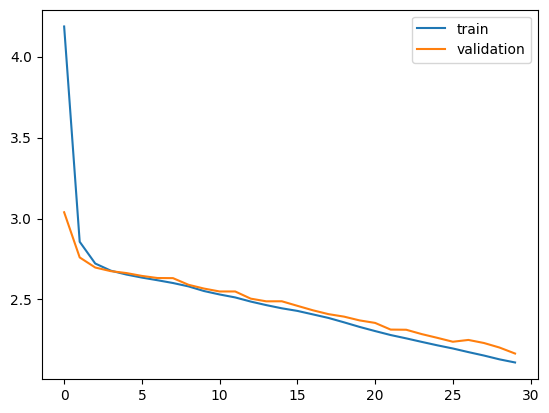

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [22]:
# Load the saved model
model = load_model('model.h1.23_Nov_24.keras')

In [23]:
import numpy as np

# Assuming the model output probabilities
preds = np.argmax(model.predict(testX.reshape((testX.shape[0], testX.shape[1]))), axis=-1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [24]:
preds

array([[ 6, 11,  5, ...,  0,  0,  0],
       [12,  3, 10, ...,  0,  0,  0],
       [21,  4,  5, ...,  0,  0,  0],
       ...,
       [ 1, 11,  5, ...,  0,  0,  0],
       [40,  4,  5, ...,  0,  0,  0],
       [20, 10, 10, ...,  0,  0,  0]])

In [25]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [27]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})